<a href="https://colab.research.google.com/github/CristinaMarsh/Reproduce/blob/main/TimeSeries/Transformer_Time_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Thanks https://github.com/mlpotter/Transformer_Time_Series

In [1]:
! git clone https://github.com/mlpotte  r/Transformer_Time_Series.git

Cloning into 'Transformer_Time_Series'...
remote: Enumerating objects: 171, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 171 (delta 1), reused 6 (delta 0), pack-reused 163
Receiving objects: 100% (171/171), 5.04 MiB | 4.98 MiB/s, done.
Resolving deltas: 100% (71/71), done.


In [2]:
%cd Transformer_Time_Series/

/content/Transformer_Time_Series


In [3]:
import os
os.system("/content/Transformer_Time_Series")

32256

In [4]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import causal_convolution_layer
import Dataloader

In [5]:
import math
from torch.utils.data import DataLoader

In [6]:
class TransformerTimeSeries(torch.nn.Module):
    """
    Time Series application of transformers based on paper
    
    causal_convolution_layer parameters:
        in_channels: the number of features per time point
        out_channels: the number of features outputted per time point
        kernel_size: k is the width of the 1-D sliding kernel
        
    nn.Transformer parameters:
        d_model: the size of the embedding vector (input)
    
    PositionalEncoding parameters:
        d_model: the size of the embedding vector (positional vector)
        dropout: the dropout to be used on the sum of positional+embedding vector
    
    """
    def __init__(self):
        super(TransformerTimeSeries,self).__init__()
        self.input_embedding = causal_convolution_layer.context_embedding(2,256,9)
        self.positional_embedding = torch.nn.Embedding(512,256)

        
        self.decode_layer = torch.nn.TransformerEncoderLayer(d_model=256,nhead=8)
        self.transformer_decoder = torch.nn.TransformerEncoder(self.decode_layer, num_layers=3)
        
        self.fc1 = torch.nn.Linear(256,1)
        
    def forward(self,x,y,attention_masks):
        
        # concatenate observed points and time covariate
        # (B*feature_size*n_time_points)
        z = torch.cat((y.unsqueeze(1),x.unsqueeze(1)),1)

        # input_embedding returns shape (Batch size,embedding size,sequence len) -> need (sequence len,Batch size,embedding_size)
        z_embedding = self.input_embedding(z).permute(2,0,1)
        
        # get my positional embeddings (Batch size, sequence_len, embedding_size) -> need (sequence len,Batch size,embedding_size)
        positional_embeddings = self.positional_embedding(x.type(torch.long)).permute(1,0,2)
        
        input_embedding = z_embedding+positional_embeddings
        
        transformer_embedding = self.transformer_decoder(input_embedding,attention_masks)

        output = self.fc1(transformer_embedding.permute(1,0,2))
        
        return output
        

In [7]:
t0 = 24

In [8]:
# train_dataset = Dataloader.time_series_decoder_missing_paper(t0,4500) # missing
# validation_dataset = Dataloader.time_series_decoder_missing_paper(t0,500) # missing 
# test_dataset = Dataloader.time_series_decoder_missing_paper(t0,1000) # missing

train_dataset = Dataloader.time_series_decoder_paper(t0,4500)
validation_dataset = Dataloader.time_series_decoder_paper(t0,500)
test_dataset = Dataloader.time_series_decoder_paper(t0,1000)

x: 4500*48 fx: 4500*48
x: 500*48 fx: 500*48
x: 1000*48 fx: 1000*48


In [9]:
criterion = torch.nn.MSELoss()
train_dl = DataLoader(train_dataset,batch_size=32,shuffle=True)
validation_dl = DataLoader(validation_dataset,batch_size=64)
test_dl = DataLoader(test_dataset,batch_size=128)

model = TransformerTimeSeries().cuda()

lr = .0005 # learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
epochs = 100

In [10]:
def Dp(y_pred,y_true,q):
    return max([q*(y_pred-y_true),(q-1)*(y_pred-y_true)])

def Rp_num_den(y_preds,y_trues,q):
    numerator = np.sum([Dp(y_pred,y_true,q) for y_pred,y_true in zip(y_preds,y_trues)])
    denominator = np.sum([np.abs(y_true) for y_true in y_trues])
    return numerator,denominator    

In [11]:
def train_epoch(model,train_dl,t0=96):
    model.train()
    train_loss = 0
    n = 0
    for step,(x,y,attention_masks) in enumerate(train_dl):
        optimizer.zero_grad()
        output = model(x.cuda(),y.cuda(),attention_masks[0].cuda())
        loss = criterion(output.squeeze()[:,(t0-1):(t0+24-1)],y.cuda()[:,t0:]) # not missing data
        # loss = criterion(output.squeeze()[:,(t0-1-10):(t0+24-1-10)],y.cuda()[:,(t0-10):]) # missing data
        loss.backward()
        optimizer.step()
        
        train_loss += (loss.detach().cpu().item() * x.shape[0])
        n += x.shape[0]
    return train_loss/n

def eval_epoch(model,validation_dl,t0=96):
    model.eval()
    eval_loss = 0
    n = 0
    with torch.no_grad():
        for step,(x,y,attention_masks) in enumerate(validation_dl):
            output = model(x.cuda(),y.cuda(),attention_masks[0].cuda())
            loss = criterion(output.squeeze()[:,(t0-1):(t0+24-1)],y.cuda()[:,t0:]) # not missing data
            # loss = criterion(output.squeeze()[:,(t0-1-10):(t0+24-1-10)],y.cuda()[:,(t0-10):]) # missing data
            
            eval_loss += (loss.detach().cpu().item() * x.shape[0])
            n += x.shape[0]
            
    return eval_loss/n    

In [12]:
def test_epoch(model,test_dl,t0=96):
    with torch.no_grad():
        predictions = []
        observations = []

        model.eval()
        for step,(x,y,attention_masks) in enumerate(test_dl):
            output = model(x.cuda(),y.cuda(),attention_masks[0].cuda())

            for p,o in zip(output.squeeze()[:,(t0-1):(t0+24-1)].cpu().numpy().tolist(),y.cuda()[:,t0:].cpu().numpy().tolist()): # not missing data
            #for p,o in zip(output.squeeze()[:,(t0-1-10):(t0+24-1-10)].cpu().numpy().tolist(),y.cuda()[:,(t0-10):].cpu().numpy().tolist()): # missing data


                predictions.append(p)
                observations.append(o)

        num = 0
        den = 0
        for y_preds,y_trues in zip(predictions,observations):
            num_i,den_i = Rp_num_den(y_preds,y_trues,.5)
            num+=num_i
            den+=den_i
        Rp = (2*num)/den
        
    return Rp

In [13]:
train_epoch_loss = []
eval_epoch_loss = []
Rp_best = 10
for e,epoch in enumerate(range(epochs)):
    train_loss = []
    eval_loss = []
    
    l_t = train_epoch(model,train_dl,t0)
    train_loss.append(l_t)
    
    l_e = eval_epoch(model,validation_dl,t0)
    eval_loss.append(l_e)
    
    Rp = test_epoch(model,test_dl,t0)

    if Rp_best > Rp:
        Rp_best = Rp
        
    train_epoch_loss.append(np.mean(train_loss))
    eval_epoch_loss.append(np.mean(eval_loss))
    
    print("Epoch {}: Train loss: {} \t Validation loss: {} \t R_p={}".format(e,
                                                             np.mean(train_loss),
                                                             np.mean(eval_loss),Rp))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch 0: Train loss: 3855.070236545139 	 Validation loss: 2708.474283203125 	 R_p=0.6068055847548273
Epoch 1: Train loss: 1868.456913953993 	 Validation loss: 1142.31028125 	 R_p=0.34916928742883063
Epoch 2: Train loss: 713.241834391276 	 Validation loss: 407.81847290039065 	 R_p=0.17603235397641953
Epoch 3: Train loss: 259.5163845214844 	 Validation loss: 153.33829809570312 	 R_p=0.09210799845486403
Epoch 4: Train loss: 102.74492778523764 	 Validation loss: 64.07241973876953 	 R_p=0.05834002500150576
Epoch 5: Train loss: 45.73992554389106 	 Validation loss: 29.566722793579103 	 R_p=0.03776154642138353
Epoch 6: Train loss: 22.967662300109865 	 Validation loss: 17.42314749145508 	 R_p=0.035364147948290466
Epoch 7: Train loss: 13.114170327928331 	 Validation loss: 8.905201332092286 	 R_p=0.02207932948533333
Epoch 8: Train loss: 8.249496246761746 	 Validation loss: 5.935103160858154 	 R_p=0.020184516688489203
Epoch 9: Train loss: 5.677854143354628 	 Validation loss: 4.397906116485595 	 R_

In [14]:
print("Rp best={}".format(Rp_best))

Rp best=0.011912970562659954


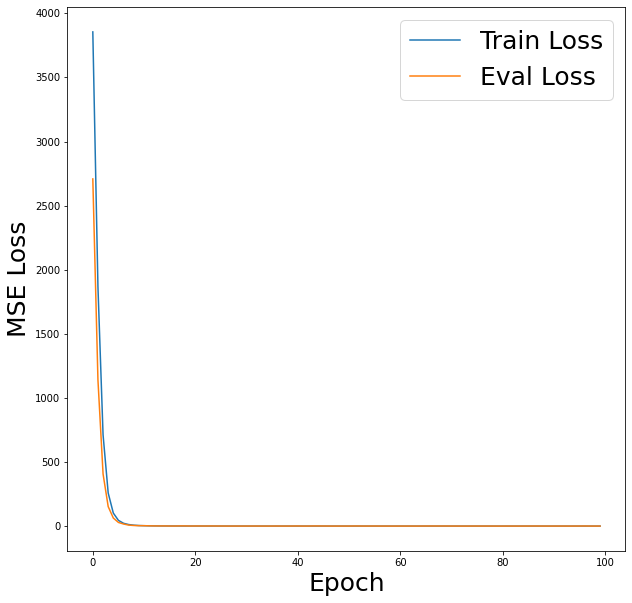

In [15]:
plt.figure(figsize=(10,10))
plt.plot(train_epoch_loss)
plt.plot(eval_epoch_loss)
plt.legend(['Train Loss','Eval Loss'],fontsize=25)
plt.xlabel("Epoch",fontsize=25)
plt.ylabel("MSE Loss",fontsize=25)
plt.show()

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


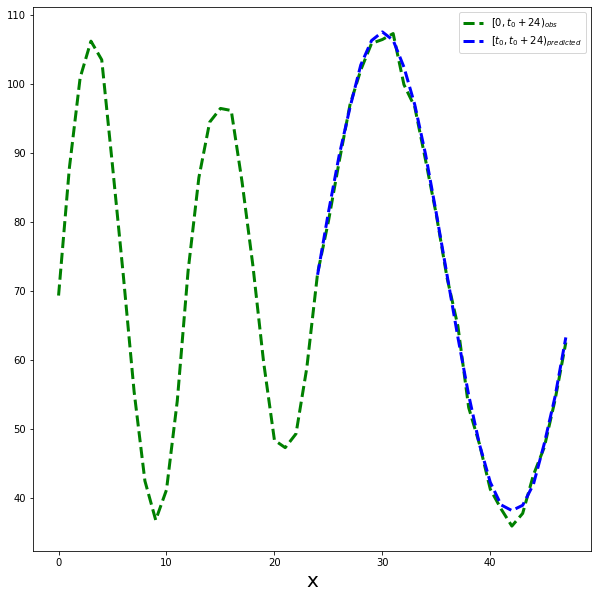

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


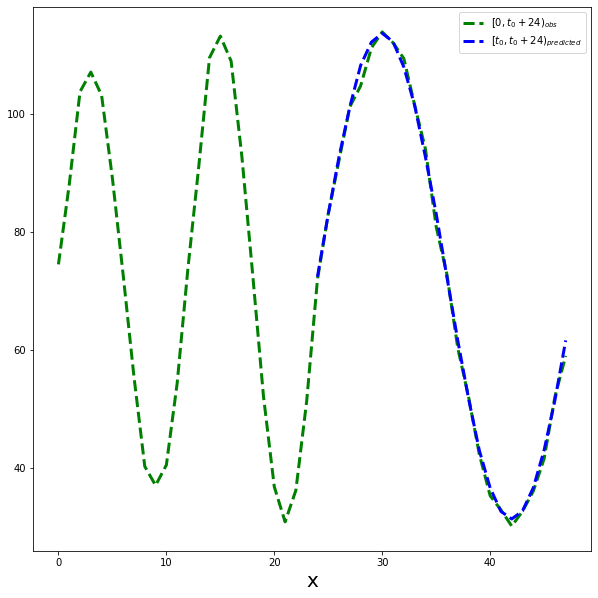

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


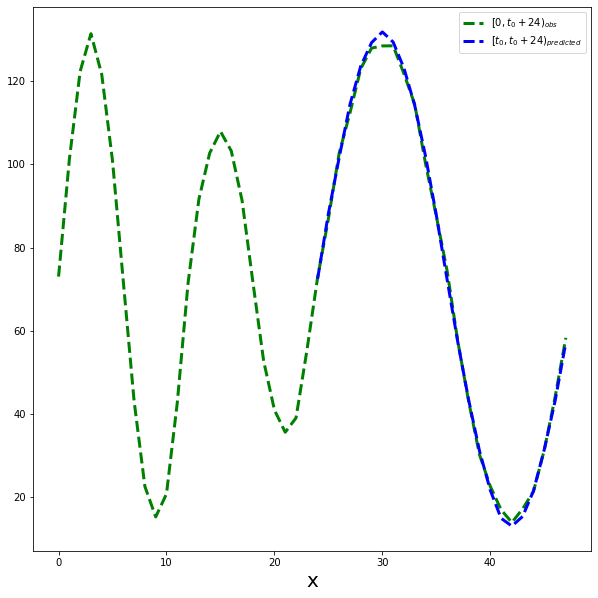

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


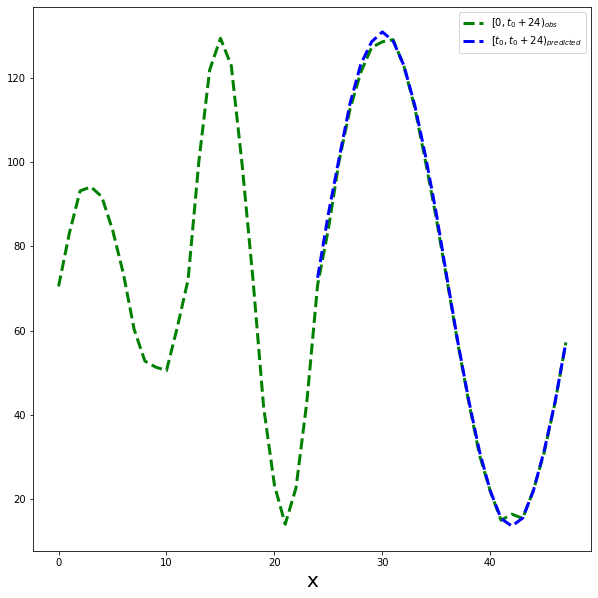

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


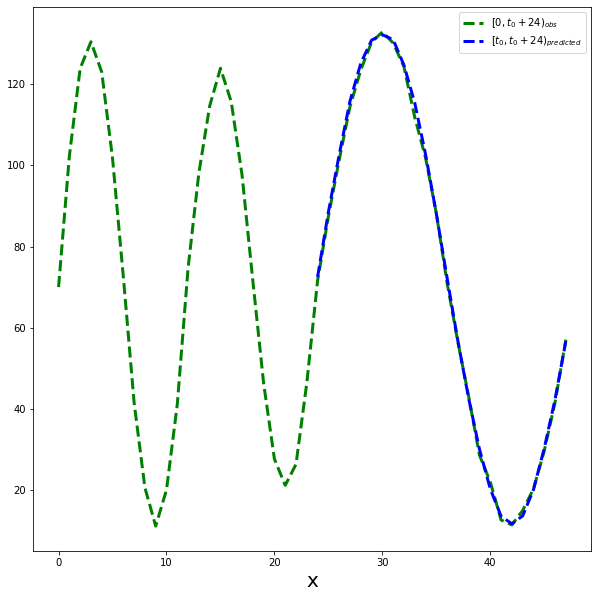

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


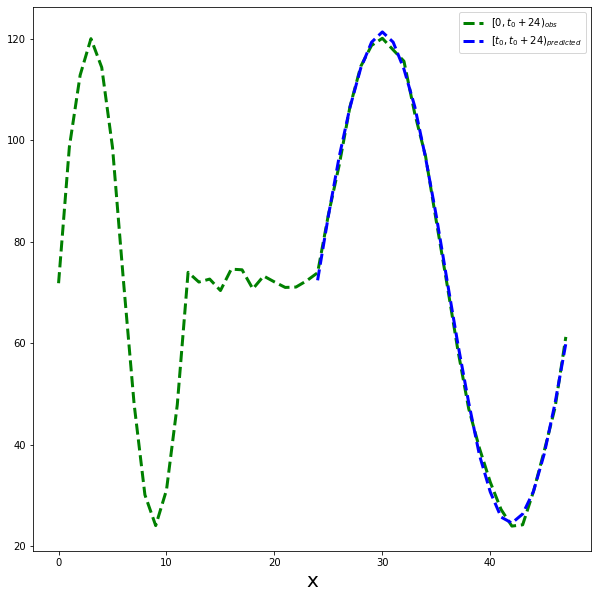

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [16]:
n_plots = 5
with torch.no_grad():
    model.eval()
    for step,(x,y,attention_masks) in enumerate(test_dl):
            output = model(x.cuda(),y.cuda(),attention_masks[0].cuda())

            if step > n_plots:
                break

            with torch.no_grad():
                plt.figure(figsize=(10,10))
                plt.plot(x[0].cpu().detach().squeeze().numpy(),y[0].cpu().detach().squeeze().numpy(),'g--',linewidth=3)
                plt.plot(x[0,t0:].cpu().detach().squeeze().numpy(),output[0,(t0-1):(t0+24-1)].cpu().detach().squeeze().numpy(),'b--',linewidth=3) # not missing data
                # plt.plot(x[0,(t0-10):].cpu().detach().squeeze().numpy(),output[0,(t0-1-10):(t0+24-1-10)].cpu().detach().squeeze().numpy(),'b--',linewidth=3) # missing data
                plt.xlabel("x",fontsize=20)
                plt.legend(["$[0,t_0+24)_{obs}$","$[t_0,t_0+24)_{predicted}$"])
                plt.show()

In [17]:
def get_attn(model,x,y,attention_masks):
    model.eval()
    with torch.no_grad():
        x=x.cuda(); y=y.cuda(); attention_masks = attention_masks.cuda()
        z = torch.cat((y.unsqueeze(1),x.unsqueeze(1)),1)
        z_embedding = model.input_embedding(z).permute(2,0,1)
        positional_embeddings = model.positional_embedding(x.type(torch.long)).permute(1,0,2)
        input_embedding = z_embedding+positional_embeddings
                
        attn_layer_i = []
        for layer in model.transformer_decoder.layers:
            attn_layer_i.append(layer.self_attn(input_embedding,input_embedding,input_embedding,attn_mask=attention_masks)[-1].squeeze().cpu().detach().numpy())
            input_embedding = layer.forward(input_embedding,attention_masks)
        
        return attn_layer_i

In [18]:
idx_example = 5

In [19]:
attn_layers = get_attn(model,test_dataset[idx_example][0].unsqueeze(0),test_dataset[idx_example][1].unsqueeze(0),test_dataset[idx_example][2])

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


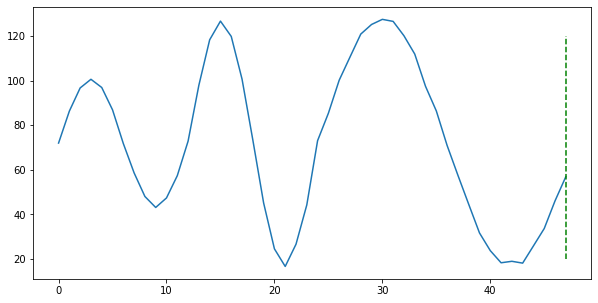

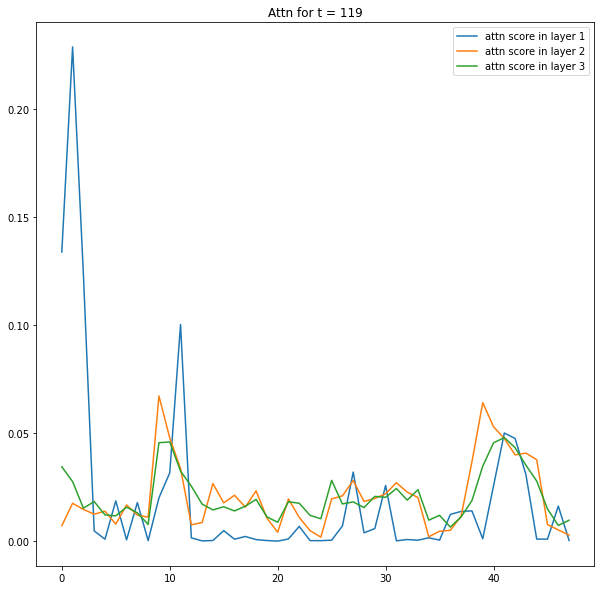

In [20]:
plt.figure(figsize=(10,5))
plt.plot(test_dataset[idx_example][0].numpy(),train_dataset[10][1].numpy())
plt.plot([t0+24-1,t0+24-1],[20,120],'g--') # not missing data
# plt.plot([t0+24-1,t0+24-1],[20,120],'g--') # missing data
plt.figure(figsize=(10,10))
plt.plot(attn_layers[0][t0+24-1]) # not missing data
plt.plot(attn_layers[1][t0+24-1]) # not missing data
plt.plot(attn_layers[2][t0+24-1]) # not missing data

#plt.plot(train_dataset[idx_example][0].numpy(),attn_layers[0][119-10]) # missing data
#plt.plot(train_dataset[idx_example][0].numpy(),attn_layers[1][119-10]) # missing data
#plt.plot(train_dataset[idx_example][0].numpy(),attn_layers[2][119-10]) # missing data



plt.legend(["attn score in layer 1","attn score in layer 2","attn score in layer 3"])
plt.title("Attn for t = 119") # not missing data

plt.show()